# Poster Figures

Make figures for the poster

In [170]:
import sys
import pathlib
import itertools
import warnings

import asdf
import astropy.units as u
import astropy.table
import eispac.core
import ndcube
import numpy as np
import matplotlib.pyplot as plt
import sunpy.map
import sunpy.time
import synthesizAR

from astropy.coordinates import SkyCoord
from matplotlib.lines import Line2D
from sunpy.coordinates import propagate_with_solar_surface, SphericalScreen
from sunpy.extern import parse
from sunkit_dem import Model
from synthesizAR.analysis import make_slope_map, log_log_linear_fit

project_dir = pathlib.Path('../../../../projects/active-region-evolution-study/')
data_dir = project_dir / 'data'
obs_dir = data_dir / 'observations'
figure_dir = pathlib.Path('../src/figures/')

sys.path.append((project_dir / 'scripts').absolute().as_posix())
import map_sources
import geometry
import dem
sys.path.append('../scripts/')
from util import get_figure_size

In [2]:
ar_cat = astropy.table.QTable.read(
    data_dir / 'active_region_rotations_no_flares_eis_curated_2011_2019.asdf'
)

In [3]:
def get_ar_dir(row):
    return obs_dir / f'{row['ID']}' / f'{row['NOAA']}'

In [4]:
TEX_COL_WIDTH = 760.53693  # I found this by putting \showthe\columnwidth in my document
get_figure_size(TEX_COL_WIDTH) # copy this into your matplotlibrc file or use this function every time 

(10.523549605645496, 6.503911338584469)

## Active Region FoV Maps

Make an image that shows the relative position of the AIA AR bounding box as well as the EIS bounding box (original and derotated). The legend can show the relative dates of the AIA and EIS observations.

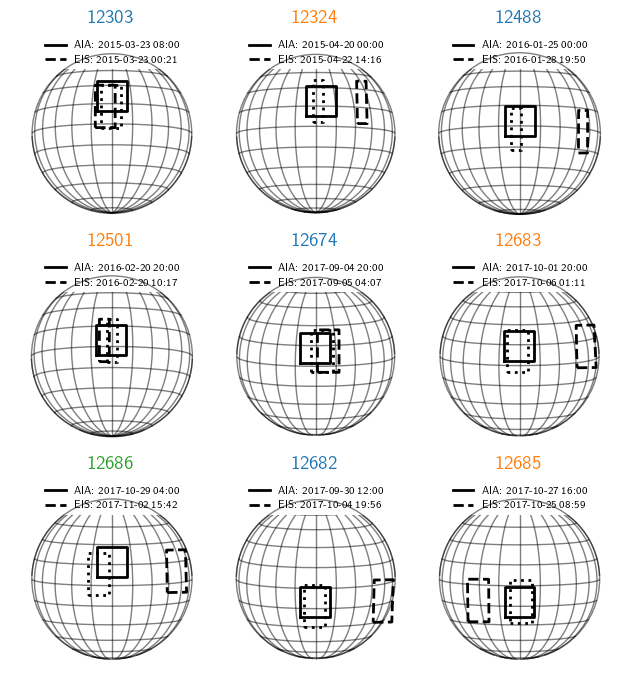

In [149]:
fig_width = 0.75*plt.rcParams['figure.figsize'][0]
fig = plt.figure(figsize=(fig_width, 1.1*fig_width))
ar_groups = ar_cat.group_by('ID').groups
for idx_group,group in zip(ar_groups.indices, ar_groups):
    for j,row in enumerate(group):
        observer = row['AR Bbox'].observer[0]
        m = geometry.make_empty_map(observer=observer)
        ax = fig.add_subplot(3, 3, idx_group+j+1, projection=m)
        m.plot(axes=ax,annotate=False)
        m.draw_grid(color='k', alpha=0.5, lw=1)
        m.draw_limb(axes=ax, color='k', alpha=0.5, lw=1)
        # Plot AR bounding box
        ax.plot_coord(row['AR Bbox'],
                      color='k',
                      label=f'AIA: {row['AR Bbox'].observer.obstime[0].strftime('%Y-%m-%d %H:%M')}')
        # Plot EIS FoV
        with SphericalScreen(row['EIS Bbox'].observer[0], only_off_disk=True):
            ax.plot_coord(row['EIS Bbox'],
                          label=f'EIS: {row['EIS Bbox'].observer.obstime[0].strftime('%Y-%m-%d %H:%M')}',
                          color='k',
                          ls='--')
            with sunpy.coordinates.propagate_with_solar_surface():
                dlon, dlat = row['EIS Bbox'][0].spherical_offsets_to(row['EIS Bbox'][2])
                center = row['EIS Bbox'][0].spherical_offsets_by(dlon/2, dlat/2).transform_to(row['AR Bbox'][0].frame)
            eis_rectangle = center.spherical_offsets_by(dlon/[-2,2,2,-2,-2], dlat/[-2,-2,2,2,-2])
            ax.plot_coord(eis_rectangle, color='k', ls=':')
        # Label and tick styling
        ax.set_xlabel('')
        ax.set_ylabel('')
        for coord in ax.coords:
            coord.frame.set_linewidth(0)
            coord.set_ticks_visible(False)
            coord.set_ticklabel_visible(False)
        leg = ax.legend(fontsize=plt.rcParams['legend.fontsize']*0.75,
                        handlelength=2,
                        frameon=True,
                        framealpha=1,
                        loc='upper center')
        leg.get_frame().set_linewidth(0)
        ax.set_title(f'{row['NOAA']}', color=f'C{j}')
plt.subplots_adjust(hspace=0.0, wspace=0.0)
fig.savefig(figure_dir / 'aia_eis_fulldisk_bbox.pgf')

## AIA Cutouts and EIS Rasters

Specify a few manually selected small bounding boxes from which we will average the intensity and compute a 1D emission measure

In [115]:
eis_dem_bbox_width = [20,20] * u.arcsec
eis_dem_bbox_center = {
    '12303_12303': (-70,460),
    '12303_12324': (560,400),
    '12488_12488': (795,150),
    '12488_12501': (-85,220),
    '12674_12674': (60,100),
    '12674_12683': (730,160),
    '12674_12686': (780,190),
    '12682_12682': (790,-190),
    '12682_12685': (-490,-200),
}
for row in ar_cat:
    m_eis = sunpy.map.Map((get_ar_dir(row) / 'EIS' / 'level_2.5').glob('eis_*.fe_12_195_119.2c-0.int.fits'))
    key = f'{row['ID']}_{row['NOAA']}'
    eis_dem_bbox_center[key] = SkyCoord(*eis_dem_bbox_center[key], unit='arcsec', frame=m_eis.coordinate_frame)
eis_dem_bbox = {}
for k,v in eis_dem_bbox_center.items():
    eis_dem_bbox[k] = v.spherical_offsets_by(
        eis_dem_bbox_width[0]/[-2,2,2,-2,-2],
        eis_dem_bbox_width[1]/[-2,-2,2,2,-2],
    )

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Miss

In [384]:
def parse_time_from_jsoc_filename(filename,wavelength):
    pattern = f'aia.lev2_euv_12s.{{}}T{{}}Z.{wavelength}.image.fits'
    res = parse(pattern, filename)
    return f'{''.join(res[0].split('-'))}_{res[1]}'

In [385]:
def find_closest_file(ref_time, filenames, wavelength):
    file_times = parse_time([parse_time_from_jsoc_filename(f.name,wavelength) for f in filenames])
    idx_file = np.argmin(np.fabs((ref_time - file_times).to_value('s')))
    return filenames[idx_file]

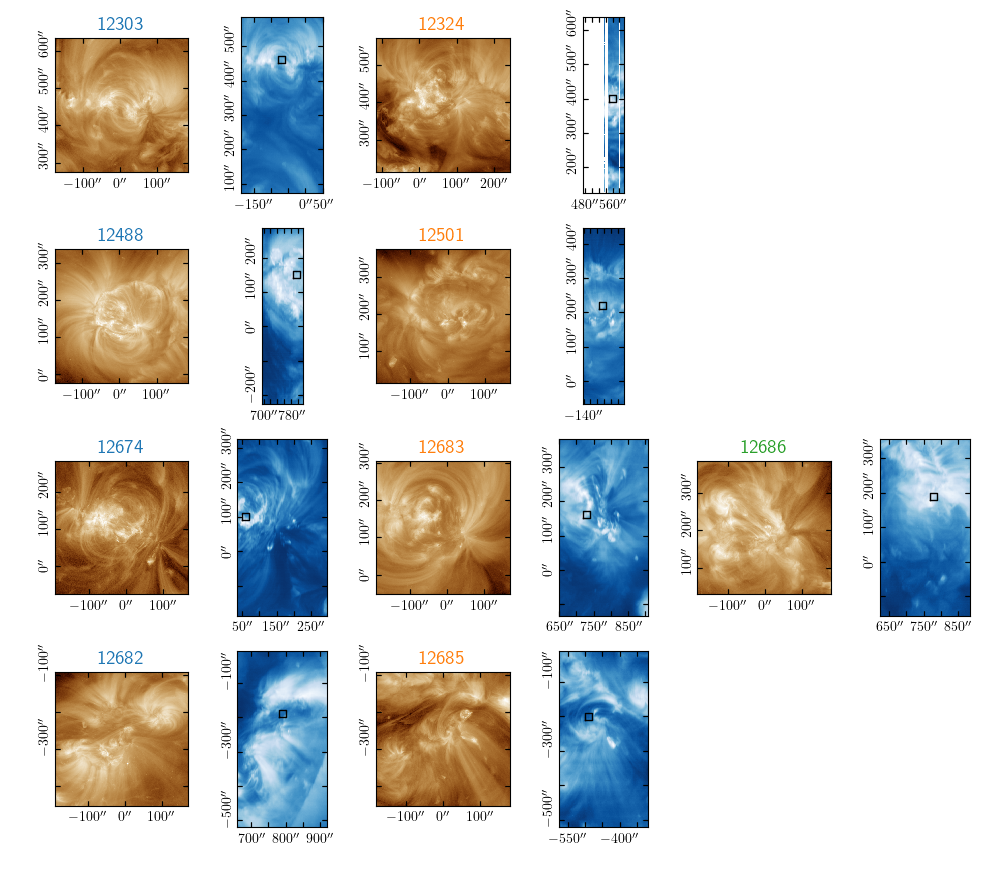

In [278]:
ncol = 6
fig = plt.figure(figsize=(1.15*plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][0]))
for i,group in enumerate(ar_cat.group_by('ID').groups):
    for j,row in enumerate(group):
        # Find the filename that is closest to the middle of the observation
        aia_files = sorted((get_ar_dir(row) / 'AIA' / 'level_2').glob('aia*.193.image.fits'))
        aia_file_times = parse_time([parse_time_from_jsoc_filename(f.name, '193') for f in aia_files])
        idx_aia = np.argmin(np.fabs((row['AR Bbox'].observer.obstime[0] - aia_file_times).to_value('s')))
        # AIA cutout
        m_aia = sunpy.map.Map(aia_files[idx_aia])
        ax_aia = fig.add_subplot(4,6,ncol*i+2*j+1,projection=m_aia)
        m_aia.plot(axes=ax_aia, title=False)
        ax_aia.coords.grid(False)
        ax_aia.coords[0].set_axislabel(' ')
        ax_aia.coords[1].set_axislabel(' ')
        ax_aia.coords[0].set_ticklabel(exclude_overlapping=True)
        ax_aia.coords[1].set_ticklabel(rotation='vertical', exclude_overlapping=True)
        ax_aia.set_title(row['NOAA'], color=f'C{j}')
        # EIS raster
        m_eis = sunpy.map.Map((get_ar_dir(row) / 'EIS' / 'level_2.5').glob('eis_*.fe_12_195_119.2c-0.int.fits'))
        ax_eis = fig.add_subplot(4,6,ncol*i+2*j+2,projection=m_eis)
        m_eis.plot(axes=ax_eis, title=False)
        ax_eis.plot_coord(eis_dem_bbox[f'{row['ID']}_{row['NOAA']}'], color='k', lw=1)
        ax_eis.coords.grid(False)
        ax_eis.coords[0].set_axislabel(' ')
        ax_eis.coords[1].set_axislabel(' ')
        ax_eis.coords[0].set_ticks(number=5)
        ax_eis.coords[0].set_ticklabel(exclude_overlapping=True)
        ax_eis.coords[1].set_ticklabel(rotation='vertical', exclude_overlapping=True)
fig.savefig(figure_dir / 'aia_cutouts_eis_rasters.pgf')

## EM Analysis

In [363]:
line_table = astropy.table.QTable.read(data_dir / 'eis_ar_dem_line_list.asdf')
idx_drop = np.where(
    (line_table['Name'] == 'Ca XVI 208.604')
    | (line_table['Name'] == ['Ar XIV 194.396'])
)
line_table.remove_rows(idx_drop)

In [364]:
kernels = {'.'.join(r['Template filename'].split('.')[:-2]): r['Contribution Function'] for r in line_table}

In [365]:
eis_1d_collections = {}
for row in ar_cat:
    # Build EIS collection
    eis_dir = get_ar_dir(row) / 'EIS' / 'level_2.5' 
    _m_eis_ref = sunpy.map.Map(eis_dir.glob('eis_*.fe_12_195_119.2c-0.int.fits'))
    _collection = dem.eis_maps_to_collection(eis_dir, line_table, _m_eis_ref.wcs, error_percentage=0.2)
    _cubes = []
    # Crop and rebin to 1D collection
    for k in _collection:
        _crop_cube = _collection[k].crop(*eis_dem_bbox[f'{row['ID']}_{row['NOAA']}'])
        _crop_cube = _crop_cube.rebin(_crop_cube.shape,
                                      operation=np.mean,
                                      operation_ignores_mask=False,
                                      propagate_uncertainties=True)
        _crop_cube.uncertainty = 0.2*_crop_cube.data
        _cubes.append((k, _crop_cube))
    eis_1d_collections[f'{row['ID']}_{row['NOAA']}'] = ndcube.NDCollection(
        _cubes,
        aligned_axes=(0,1)
    )

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 15/19 [00:02<00:00,  6.02it/s]/Users/wtbarnes/Documents/presentations/posters/hinode-2025-poster/notebooks/../../../../projects/active-region-evolution-study/scripts/dem.py:69: UserWarning: No data available for fe_14_264_787.1c in ../../../../projects/active-region-evolution-study/data/observations/12674/12674/EIS/level_2.5.
  warnings.warn(f'No data available for {line_label} in {root_dir}.')
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  6.33it/s]


### EM Distributions

In [366]:
dem_settings = {
    'alpha': 1.1,
    'increase_alpha': 1.3,
    'max_iterations': 1000,
    'use_em_loci': False,
    'emd_int': False,
    'l_emd': False,
    'guess': 1,
}
delta_log_t = 0.1
temperature_bin_edges = 10**np.arange(5.3, 7.5+delta_log_t, delta_log_t) * u.K

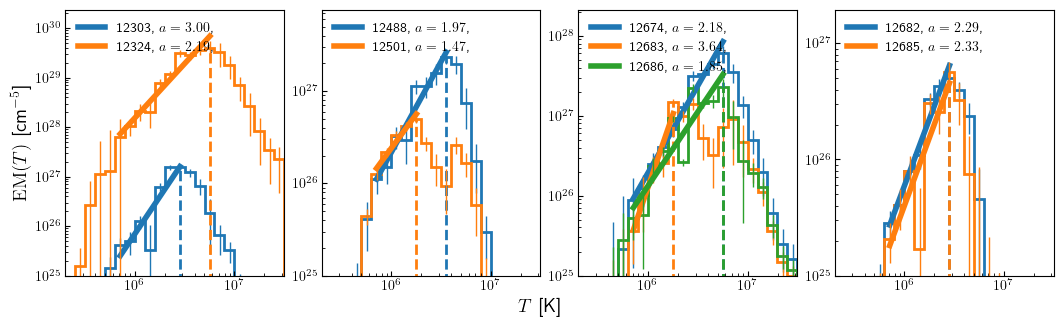

In [367]:
fig, axes = plt.subplots(1,4,
                         layout='constrained',
                         figsize=(plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][0]*0.3),
                         sharex=True)
for ax,group in zip(axes.flatten(),ar_cat.group_by('ID').groups):
    for row in group:
        key = f'{row['ID']}_{row['NOAA']}'
        dem_model = Model(eis_1d_collections[key],
                          {k:v for k,v in kernels.items() if k in eis_1d_collections[key]},
                          temperature_bin_edges,
                          kernel_temperatures=line_table['Temperature Contribution Function'][0],
                          model='hk12')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            dem_res = dem_model.fit(**dem_settings)
        # Inverted distribution
        l = ax.stairs(dem_res['em'].data,
                       edges=temperature_bin_edges.to_value('K'))
        # Errorbars
        ax.errorbar(
            dem_model.temperature_bin_centers.to_value('K'),
            dem_res['em'].data,
            yerr=dem_res['dem'].uncertainty.array*dem_model.temperature_bin_widths.to_value('K'),
            ls='',
            lw=1,
            color=l.get_edgecolor(),
        )
        # EM slopes
        a_eis,xfit,yfit,r2 = log_log_linear_fit(
            dem_model.temperature_bin_centers.to_value('K'),
            dem_res['em'].quantity.to_value('cm-5'),
            7e5,
            dem_model.temperature_bin_centers[dem_res['em'].quantity.argmax()].to_value('K')
        )
        yfit = (10**xfit)**a_eis[0]*10**a_eis[1]
        xfit = 10**xfit
        ax.plot(xfit,
                yfit,
                color=l.get_edgecolor(),
                ls='-',
                lw=4,
                label=f'{row['NOAA']}, $a={a_eis[0]:.2f}$,')
        ax.vlines(dem_model.temperature_bin_centers[dem_res['em'].quantity.argmax()].to_value('K'),
                  0,
                  dem_res['em'].quantity.max().to_value('cm-5'),
                  ls='--',
                  color=l.get_edgecolor())
    #ax.set_title(f'{row['ID']}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(temperature_bin_edges[[0,-1]].to_value('K'))
    ax.set_ylim(bottom=1e25, top=None)
    ax.legend(loc=2)
axes[0].set_ylabel(r'$\mathrm{EM}(T)$ [cm$^{-5}$]')
axes[1].set_xlabel(r'$T$ [K]', x=1, ha='center')
fig.savefig(figure_dir / 'em_distributions_1d.pgf')

### EM Slopes

Maps of slopes for a single region

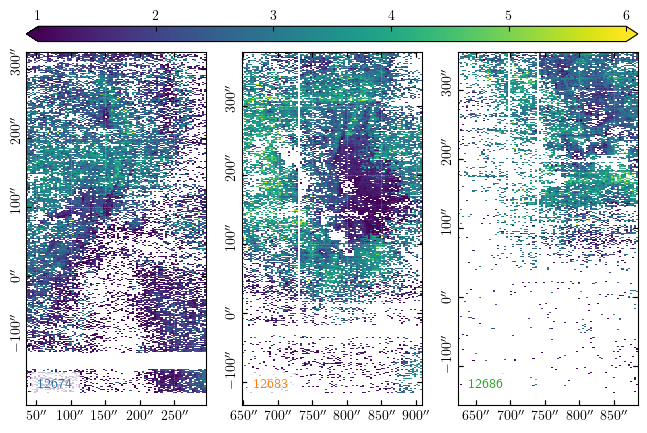

In [300]:
fig = plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*0.75,plt.rcParams['figure.figsize'][1]))
axes = []
for i,row in enumerate(ar_cat[ar_cat['ID']==12674]):
    ar_dir = data_dir / 'observations' / str(row['ID']) / str(row['NOAA']) / 'diagnostics'
    with asdf.open(ar_dir / 'dem' / f'emslope_{row['ID']}_{row['NOAA']}_eis.asdf', lazy_load=False) as af:
        m_slope = af.tree['slope_map']
    ax = fig.add_subplot(1,3,i+1,projection=m_slope)
    im = m_slope.plot(aspect=m_slope.scale.axis2/m_slope.scale.axis1,
                      axes=ax,
                      vmin=1,
                      vmax=6,
                      cmap='viridis',
                      title=False)
    ax.coords[0].set_axislabel('')
    ax.coords[1].set_axislabel('')
    ax.coords[1].set_ticklabel(rotation='vertical')
    # Active region label
    noaa_label = ax.text(5,20,row['NOAA'],va='bottom',ha='left',color=f'C{i}')
    noaa_label.set_bbox(dict(facecolor='w',alpha=0.75,edgecolor='w'))
    axes.append(ax)
axes = np.array(axes)
fig.colorbar(im,
             ax=axes,
             orientation='horizontal',
             extend='both',
             location='top',
             extendfrac=0.02,
             aspect=40,
             pad=0.02)
fig.savefig(figure_dir / 'em_slope_maps.pgf')

Histograms of slopes over all regions

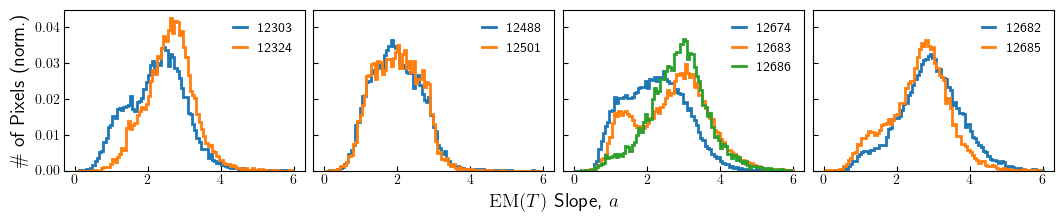

In [376]:
bins = np.linspace(0,6,100)
fig,axes = plt.subplots(1,4,
                        figsize=(plt.rcParams['figure.figsize'][0],0.2*plt.rcParams['figure.figsize'][0]),
                        layout='constrained',
                        sharex=True,
                        sharey=True)
for ax,group in zip(axes.flatten(),ar_cat.group_by('ID').groups):
    for row in group:
        ar_dir = data_dir / 'observations' / str(row['ID']) / str(row['NOAA']) / 'diagnostics'
        with asdf.open(ar_dir / 'dem' / f'emslope_{row['ID']}_{row['NOAA']}_eis.asdf', lazy_load=False) as af:
            m_slope = af.tree['slope_map']
        slope_data = m_slope.data[~m_slope.mask]
        ax.hist(slope_data,
                histtype='step',
                label=row['NOAA'],
                bins=bins,
                weights=1/len(slope_data)*np.ones(len(slope_data)),
                density=False)
    handles, labels = ax.get_legend_handles_labels()
    handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    ax.legend(handles=handles, labels=labels,loc=1, handlelength=1)
    ax.label_outer()
axes[1].set_xlabel(r'$\mathrm{EM}(T)$ Slope, $a$', x=1, ha='center')
axes[0].set_ylabel(r'\# of Pixels (norm.)')
fig.savefig(figure_dir / 'em_slope_histograms.pgf')

## Time Lags

In [223]:
channel_list = ['94', '131', '171', '193', '211', '335']
channel_combinations = list(itertools.combinations(channel_list,2))
channel_combinations = channel_combinations[:5] + [sorted(c, key=lambda x: float(x), reverse=True) for c in channel_combinations[5:]]

In [237]:
selected_channel_combinations = [
    ('94', '211'),
    ('335', '171'),
    ('211', '193'),
]

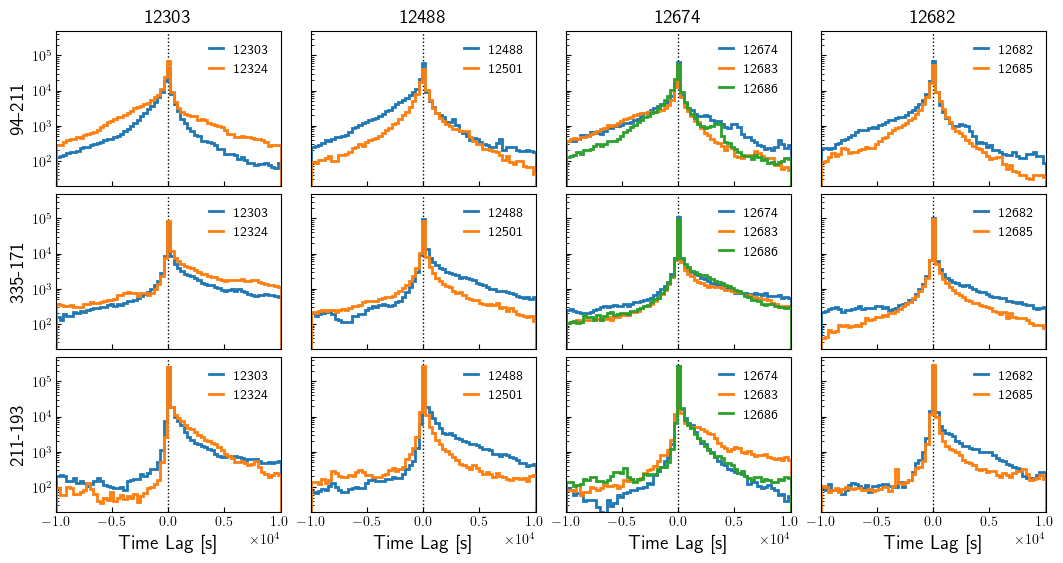

In [247]:
mc_threshold = 0.2
dt = (5*u.minute).to_value('s')
bin_lim = 1e4
bins = np.arange(-bin_lim,bin_lim+dt,dt)
fig, axes = plt.subplots(len(selected_channel_combinations),4,
                         figsize=(plt.rcParams['figure.figsize'][0],
                                  0.7*plt.rcParams['figure.figsize'][0]/4*len(selected_channel_combinations)),
                         sharex=True,
                         sharey=True,
                         layout='constrained')
for j,(ca,cb) in enumerate(selected_channel_combinations):
    for i,group in enumerate(ar_cat.group_by('ID').groups):
        axes[j,i].axvline(x=0,ls=':',color='k',lw=1)
        for row in group:
            ar_dir = data_dir / 'observations' / str(row['ID']) / str(row['NOAA']) / 'diagnostics'
            m_tl = sunpy.map.Map(ar_dir / 'time_lag' / f'timelag_{row['ID']}_{row['NOAA']}_{ca}-{cb}.fits')
            m_cc = sunpy.map.Map(ar_dir / 'max_cc' / f'maxcc_{row['ID']}_{row['NOAA']}_{ca}-{cb}.fits')
            tl_flat = m_tl.data[m_cc.data>=mc_threshold]
            axes[j,i].hist(tl_flat, histtype='step', bins=bins, label=row['NOAA'], density=False, log=True)
        handles, labels = axes[j,i].get_legend_handles_labels()
        handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
        axes[j,i].legend(handles=handles, labels=labels, loc=1, handlelength=1)
        axes[j,i].label_outer()
        axes[j,i].set_ylabel(f'{ca}-{cb}')
        axes[j,i].set_xlabel(r'Time Lag [s]')
        if j == 0:
            axes[j,i].set_title(row['ID'])
        axes[j,i].set_ylim(20,5e5)
        axes[j,i].set_xlim(bins[[0,-1]])
        axes[j,i].ticklabel_format(axis='x', style='scientific', useMathText=True, scilimits=(0, 0), useOffset=False)
        axes[j,i].label_outer()
#plt.subplots_adjust(hspace=0,wspace=0)
fig.savefig(figure_dir / 'timelag_histograms.pgf')

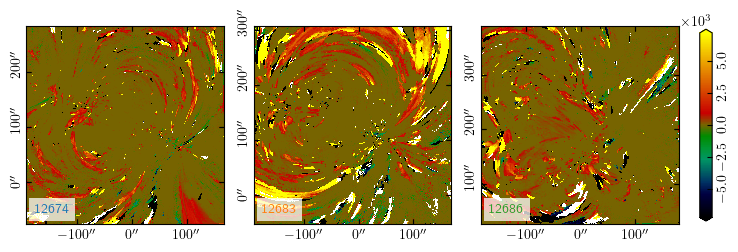

In [357]:
fig = plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*0.8,plt.rcParams['figure.figsize'][1]))
ca,cb = selected_channel_combinations[-1]
for j,row in enumerate(ar_cat[ar_cat['ID']==12674]):
    # Load time lag maps
    ar_dir = get_ar_dir(row) / 'diagnostics'
    m_tl = sunpy.map.Map(ar_dir / 'time_lag' / f'timelag_{row['ID']}_{row['NOAA']}_{ca}-{cb}.fits')
    m_cc = sunpy.map.Map(ar_dir / 'max_cc' / f'maxcc_{row['ID']}_{row['NOAA']}_{ca}-{cb}.fits')
    m_tl.mask = m_cc.data < mc_threshold
    # Plot map
    ax = fig.add_subplot(1,3,j+1,projection=m_tl)
    im = m_tl.plot(axes=ax,title=False)
    # Active region label
    noaa_label = ax.text(25,25,row['NOAA'],va='bottom',ha='left',color=f'C{j}')
    noaa_label.set_bbox(dict(facecolor='w',alpha=0.75,edgecolor='w',lw=0))
    # Axes
    ax.coords[0].set_axislabel('')
    ax.coords[1].set_axislabel('')
    ax.coords[1].set_ticklabel(rotation='vertical')
    ax.coords.grid(False)

# Colorbar
ax_pos = ax.get_position().get_points()
pad_x = 0.025  # move the colorbar off the figure a bit
height = ax_pos[1,1] - ax_pos[0,1]
cax = fig.add_axes((ax_pos[1,0] + pad_x,
                    ax_pos[0,1],
                    0.05*height,
                    height))
cbar = fig.colorbar(
    im,
    cax=cax,
    orientation='vertical',
    extend='both',
    location='right',
    extendfrac=0.02,
)
cbar.ax.tick_params(rotation=90)
for label in cbar.ax.get_yticklabels():
    label.set_verticalalignment('center')
cbar.ax.ticklabel_format(axis='y', style='scientific', useMathText=True, scilimits=(0, 0), useOffset=False)
plt.subplots_adjust(wspace=0.15,hspace=0)
fig.savefig(figure_dir / 'timelag_maps.pgf')

## Magnetic Fields

In [49]:
skeletons= {}
for row in ar_cat:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        skeletons[f'{row['ID']}_{row['NOAA']}'] = synthesizAR.Skeleton.from_asdf(
            data_dir / 'observations' / str(row['ID']) / str(row['NOAA']) / 'diagnostics' / 'magnetic_field' / 'skeleton.asdf'
        )

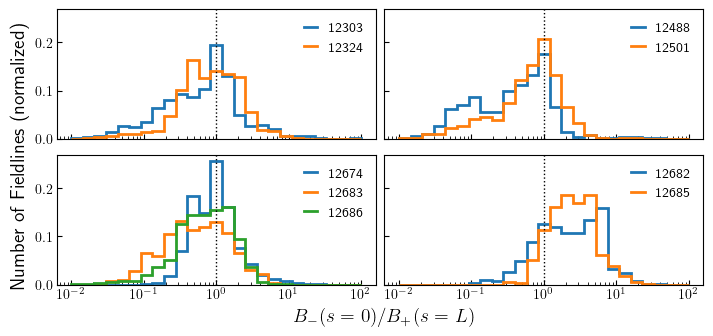

In [389]:
bins = np.logspace(-2,2,26)
fig,axes = plt.subplots(2,2,
                        figsize=(.667*plt.rcParams['figure.figsize'][0],.5*plt.rcParams['figure.figsize'][1]),
                        layout='constrained',
                        sharex=True,
                        sharey=True)
for ax,group in zip(axes.flatten(),ar_cat.group_by('ID').groups):
    for row in group:
        fieldlines = skeletons[f'{row['ID']}_{row['NOAA']}'].strands
        b_fp_ratios= np.array([f.field_strength[0]/f.field_strength[-1] for f in fieldlines])
        ax.hist(b_fp_ratios,
                histtype='step',
                bins=bins,
                weights=1/len(b_fp_ratios)*np.ones(len(b_fp_ratios)),
                label=row['NOAA'],
                density=False)
    handles, labels = ax.get_legend_handles_labels()
    handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    ax.legend(handles=handles, labels=labels, handlelength=1)
    ax.set_xscale('log')
    ax.axvline(x=1, color='k', ls=':', lw=1)
    ax.label_outer()
axes[1,1].set_xlabel('$B_-(s=0)/B_+(s=L)$', x=0, ha='center')
axes[1,0].set_ylabel('Number of Fieldlines (normalized)', y=1,)
fig.savefig(figure_dir / 'fieldline_footpoint_ratios.pgf')

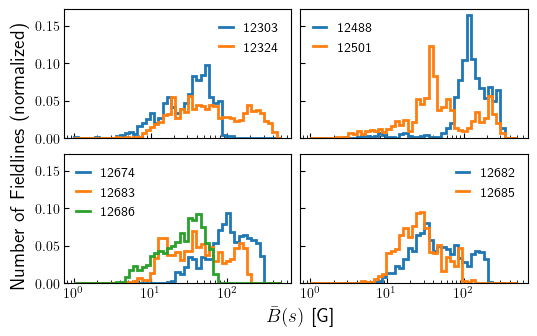

In [108]:
bins = np.logspace(0,2.7,50)
fig,axes = plt.subplots(2,2,
                        figsize=(.5*plt.rcParams['figure.figsize'][0],.5*plt.rcParams['figure.figsize'][1]),
                        layout='constrained',
                        sharex=True,
                        sharey=True)
for ax,group in zip(axes.flatten(), ar_cat.group_by('ID').groups):
    for row in group:
        fieldlines = skeletons[f'{row['ID']}_{row['NOAA']}'].strands
        b_mean = u.Quantity([f.field_strength.mean() for f in fieldlines])
        ax.hist(b_mean.to_value('G'),
                histtype='step',
                bins=bins,
                weights=1 / len(b_mean) * np.ones(len(b_mean)),
                label=row['NOAA'],
                density=False)
    handles, labels = ax.get_legend_handles_labels()
    handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    ax.legend(handles=handles, labels=labels, handlelength=1)
    ax.set_xscale('log')
    ax.label_outer()
axes[1,1].set_xlabel(r'$\bar{B}(s)$ [G]', x=0, ha='center')
axes[1,0].set_ylabel('Number of Fieldlines (normalized)', y=1)
fig.savefig(figure_dir / 'fieldline_mean_field.pgf')

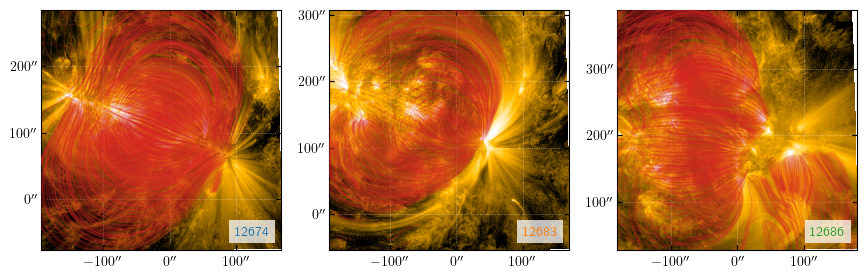

In [101]:
fig = plt.figure(figsize=(plt.rcParams['figure.figsize'][0],.5*plt.rcParams['figure.figsize'][0]))
for i,row in enumerate(ar_cat[ar_cat['ID']==12674]):
    aia_filename = find_closest_file(row['AR Bbox'].obstime[0],
                                     sorted((get_ar_dir(row) / 'AIA' / 'level_2').glob('aia*.171.image.fits')))
    m = sunpy.map.Map(aia_filename)
    ax = fig.add_subplot(1,3,i+1,projection=m)
    m.plot(axes=ax, clip_interval=(1,99.9)*u.percent, title=False)
    for strand in skeletons[f'{row['ID']}_{row['NOAA']}'].strands[::]:
        ax.plot_coord(strand.coordinate, color='C3', alpha=0.15, lw=1)
    ax.set_xlim(0,m.data.shape[1]-1)
    ax.set_ylim(0,m.data.shape[0]-1)
    ax.coords[0].set_axislabel('')
    ax.coords[1].set_axislabel('')
    noaa_label = ax.text(
        m.data.shape[1]*0.95,
        m.data.shape[0]*0.05,
        f'{row['NOAA']}',
        color=f'C{i}',
        ha='right',
        va='bottom'
    )
    noaa_label.set_bbox(dict(alpha=0.75, facecolor='w', edgecolor='w', lw=0))
fig.savefig(figure_dir / 'field_extrapolations.pgf')

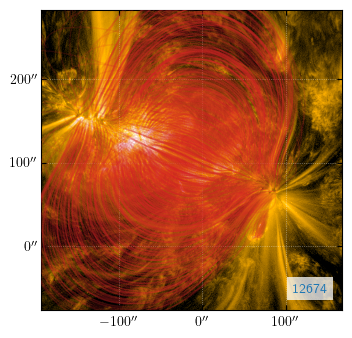

In [391]:
row = ar_cat[ar_cat['ID']==12674][0]
aia_filename = find_closest_file(row['AR Bbox'].obstime[0],
                                 sorted((get_ar_dir(row) / 'AIA' / 'level_2').glob('aia*.171.image.fits')),
                                 '171')
fig = plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*0.4,.6*plt.rcParams['figure.figsize'][1]))
m = sunpy.map.Map(aia_filename)
ax = fig.add_subplot(projection=m)
m.plot(axes=ax, clip_interval=(1,99.9)*u.percent, title=False)
for strand in skeletons[f'{row['ID']}_{row['NOAA']}'].strands[::]:
    ax.plot_coord(strand.coordinate, color='C3', alpha=0.15, lw=1)
ax.set_xlim(0,m.data.shape[1]-1)
ax.set_ylim(0,m.data.shape[0]-1)
ax.coords[0].set_axislabel('')
ax.coords[1].set_axislabel('')
noaa_label = ax.text(
    m.data.shape[1]*0.95,
    m.data.shape[0]*0.05,
    f'{row['NOAA']}',
    color=f'C0',
    ha='right',
    va='bottom'
)
noaa_label.set_bbox(dict(alpha=0.75, facecolor='w', edgecolor='w', lw=0))
fig.savefig(figure_dir / 'field_extrapolations_12674.pgf')

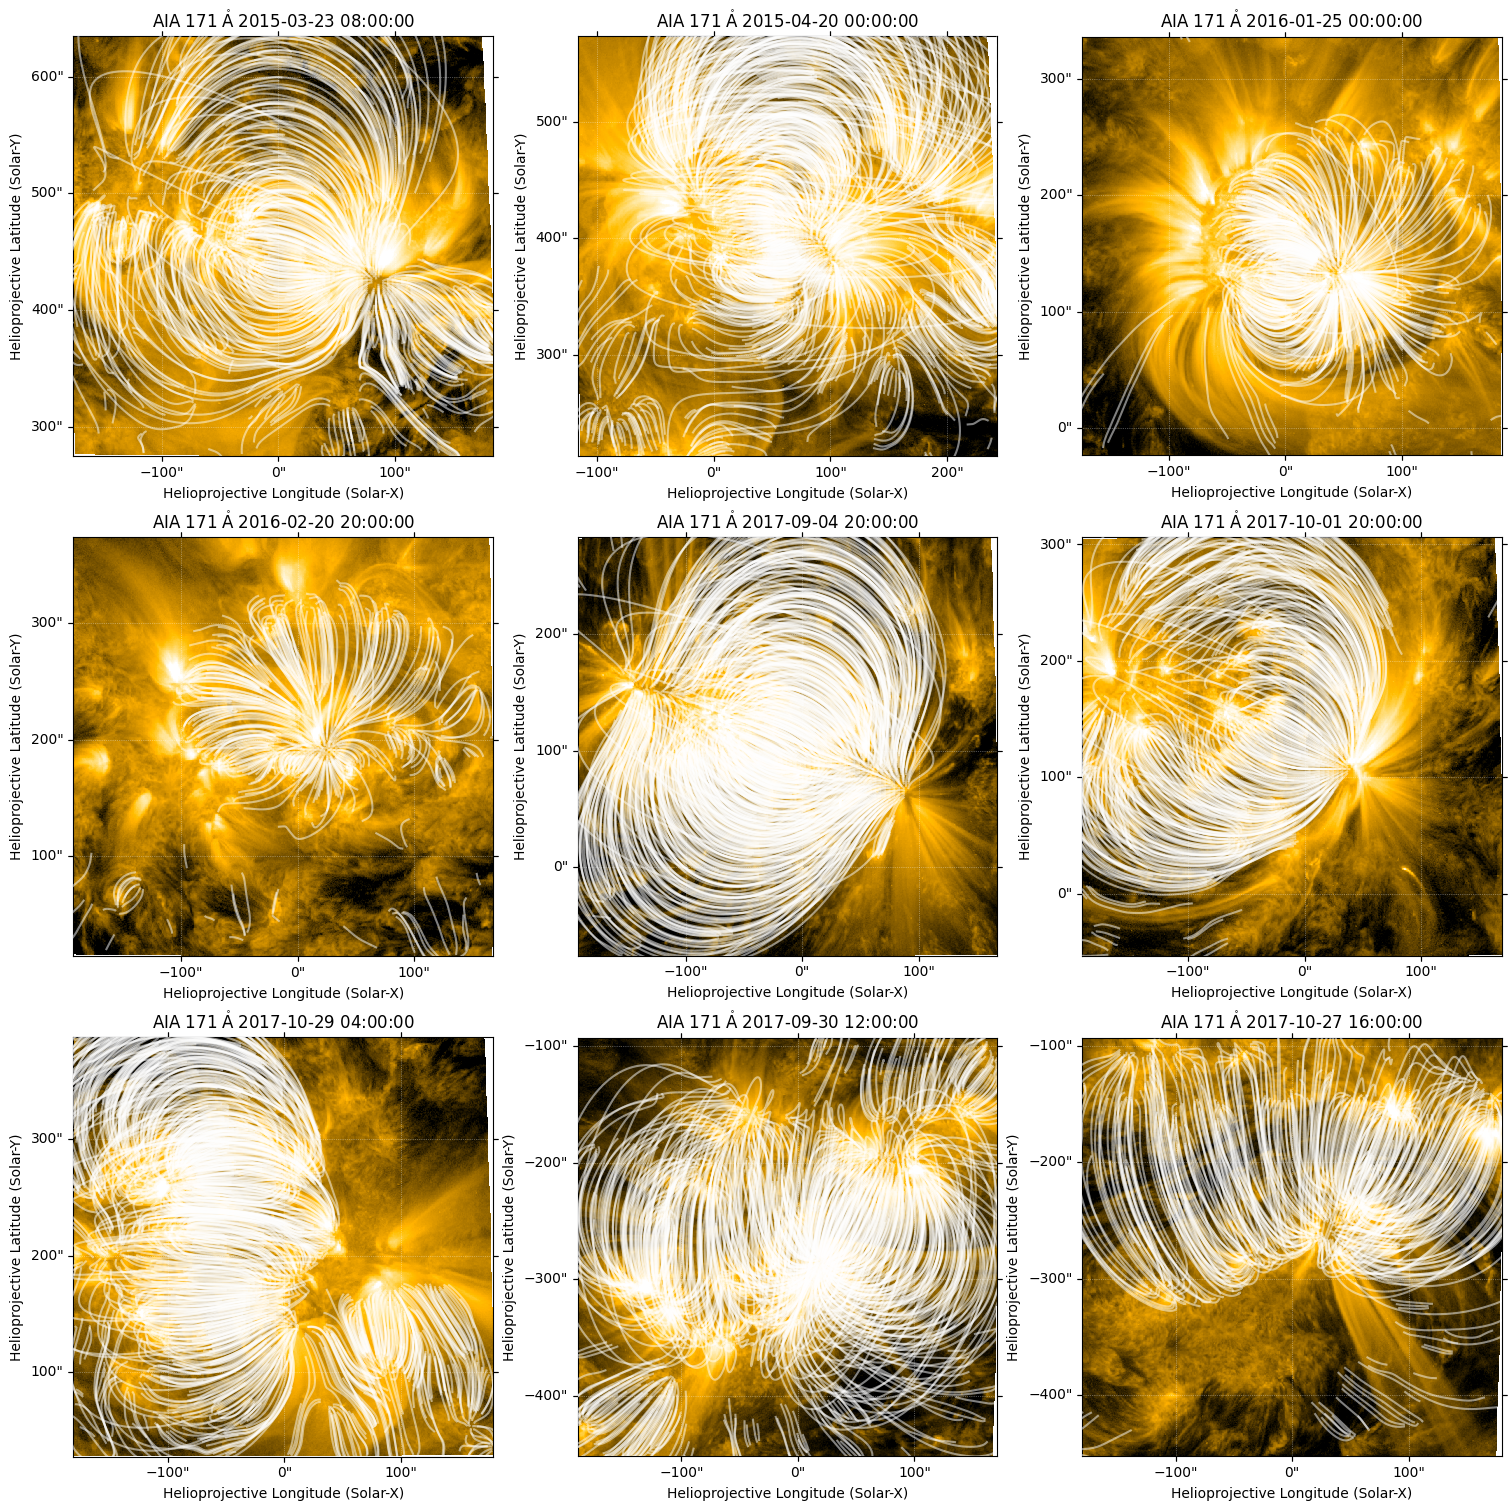

In [71]:
fig = plt.figure(layout='constrained', figsize=(15,15))
for i,row in enumerate(ar_cat):
    m = sunpy.map.Map(
        sorted((data_dir / 'observations' / str(row['ID']) / str(row['NOAA']) / 'AIA' / 'level_2').glob('aia*.171.image.fits'))[0]
    )
    ax = fig.add_subplot(3,3,i+1,projection=m)
    m.plot(axes=ax,clip_interval=(1,99.9)*u.percent)
    for strand in skeletons[f'{row['ID']}_{row['NOAA']}'].strands[::2]:
        ax.plot_coord(strand.coordinate, color='w', alpha=0.5)
    ax.set_xlim(0,m.data.shape[1]-1)
    ax.set_ylim(0,m.data.shape[0]-1)